In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import random
import pickle
import time
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
import requests
import json
import random

# Raw URLs for the JSON files
urls = [
    "https://raw.githubusercontent.com/AleksandreSukh/GeorgianWordsDataBase/master/wordsChunk_0.json",
    "https://raw.githubusercontent.com/AleksandreSukh/GeorgianWordsDataBase/master/wordsChunk_1.json",
    "https://raw.githubusercontent.com/AleksandreSukh/GeorgianWordsDataBase/master/wordsChunk_2.json",
]

all_words = []

for url in urls:
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    data = resp.json()
    if isinstance(data, list):
        all_words.extend(data)
    else:
        print(f"Unexpected format in {url}")

print(f"Total words loaded: {len(all_words)}")

sample_size = 60000
if len(all_words) > sample_size:
    all_words = random.sample(all_words, sample_size)

print(f"Random {len(all_words)} words ready")
print("Example words:", random.sample(all_words, min(15, len(all_words))))


In [ ]:
def is_valid_georgian_word(word):
    """Check if word is valid Georgian."""
    if len(word) < 2 or len(word) > 20:
        return False
    georgian_chars = set('აბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ')
    return all(c in georgian_chars for c in word)

georgian_words = [w for w in all_words if is_valid_georgian_word(w)]
print(f"After filtering: {len(georgian_words)} words")

if len(georgian_words) > 10000:
    georgian_words = random.sample(georgian_words, 50000)

print(f"Final word count: {len(georgian_words)}")
print(f"Sample words: {random.sample(georgian_words, 10)}")

In [ ]:
GEORGIAN_KEYBOARD = [
    ['ქ', 'წ', 'ე', 'რ', 'ტ', 'ყ', 'უ', 'ი', 'ო', 'პ'],
    ['ა', 'ს', 'დ', 'ფ', 'გ', 'ჰ', 'ჯ', 'კ', 'ლ'],
    ['ზ', 'ხ', 'ც', 'ვ', 'ბ', 'ნ', 'მ']
]

GEORGIAN_KEYBOARD_SHIFT = [
    ['ჭ', 'ჭ', 'ე', 'ღ', 'თ', 'ყ', 'უ', 'ი', 'ო', 'პ'],
    ['ა', 'შ', 'დ', 'ფ', 'გ', 'ჰ', 'ჟ', 'კ', 'ლ'],
    ['ძ', 'ხ', 'ჩ', 'ვ', 'ბ', 'ნ', 'მ']
]

def build_adjacency_map():
    """Build keyboard adjacency map for Georgian letters."""
    adjacency = {}
    all_chars = set()

    for row in GEORGIAN_KEYBOARD + GEORGIAN_KEYBOARD_SHIFT:
        all_chars.update(row)

    for keyboard in [GEORGIAN_KEYBOARD, GEORGIAN_KEYBOARD_SHIFT]:
        for r, row in enumerate(keyboard):
            for c, char in enumerate(row):
                if char not in adjacency:
                    adjacency[char] = set()

                # Add neighbors
                for dr in [-1, 0, 1]:
                    for dc in [-1, 0, 1]:
                        if dr == 0 and dc == 0:
                            continue
                        nr, nc = r + dr, c + dc
                        if 0 <= nr < len(keyboard) and 0 <= nc < len(keyboard[nr]):
                            adjacency[char].add(keyboard[nr][nc])

    # Convert sets to lists
    return {k: list(v) for k, v in adjacency.items()}

ADJACENCY_MAP = build_adjacency_map()
GEORGIAN_CHARS = list(set('აბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ'))

print("Adjacency map sample:")
for char in list(ADJACENCY_MAP.keys())[:5]:
    print(f"  {char}: {ADJACENCY_MAP[char]}")

In [ ]:
GEORGIAN_KEYBOARD_ROWS = [
    'ქწერტყუიოპ',
    'ასდფგჰჯკლ',
    'ზხცვბნმ'
]

def build_keyboard_adjacency():
    adjacency = {}
    all_chars = ''.join(GEORGIAN_KEYBOARD_ROWS)

    # Create position map
    pos_map = {}
    for r, row in enumerate(GEORGIAN_KEYBOARD_ROWS):
        for c, char in enumerate(row):
            pos_map[char] = (r, c)

    # Find neighbors for each character
    for char, (r, c) in pos_map.items():
        neighbors = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                nr, nc = r + dr, c + dc
                if 0 <= nr < len(GEORGIAN_KEYBOARD_ROWS):
                    row = GEORGIAN_KEYBOARD_ROWS[nr]
                    if 0 <= nc < len(row):
                        neighbors.append(row[nc])
        adjacency[char] = neighbors if neighbors else [char]

    # Add less common characters with random neighbors
    extra_chars = 'ჟღყშჩძწჭ'
    for char in extra_chars:
        if char not in adjacency:
            adjacency[char] = list(all_chars[:5])

    return adjacency

KEYBOARD_ADJACENCY = build_keyboard_adjacency()
GEORGIAN_ALPHABET = 'აბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ'

# Similar looking/sounding character pairs
CONFUSABLE_PAIRS = [
    ('ა', 'ე'), ('ე', 'ი'), ('ი', 'უ'), ('ო', 'უ'),
    ('კ', 'ქ'), ('გ', 'ღ'), ('პ', 'ფ'), ('ტ', 'თ'),
    ('ძ', 'ც'), ('წ', 'ჭ'), ('ჩ', 'ჯ'), ('შ', 'ჟ'),
    ('ს', 'ზ'), ('ხ', 'ჰ'), ('ბ', 'პ'), ('დ', 'თ'),
]
CONFUSABLES = {}
for a, b in CONFUSABLE_PAIRS:
    CONFUSABLES.setdefault(a, []).append(b)
    CONFUSABLES.setdefault(b, []).append(a)


class RobustErrorGenerator:
    def __init__(self):
        self.keyboard = KEYBOARD_ADJACENCY
        self.alphabet = list(GEORGIAN_ALPHABET)
        self.confusables = CONFUSABLES

    def keyboard_typo(self, word):
        """Replace with keyboard-adjacent character."""
        if len(word) < 2:
            return word
        positions = list(range(len(word)))
        random.shuffle(positions)
        for pos in positions:
            char = word[pos]
            if char in self.keyboard and self.keyboard[char]:
                replacement = random.choice(self.keyboard[char])
                return word[:pos] + replacement + word[pos+1:]
        return word

    def phonetic_typo(self, word):
        """Replace with phonetically similar character."""
        if len(word) < 2:
            return word
        positions = list(range(len(word)))
        random.shuffle(positions)
        for pos in positions:
            char = word[pos]
            if char in self.confusables:
                replacement = random.choice(self.confusables[char])
                return word[:pos] + replacement + word[pos+1:]
        return self.keyboard_typo(word)  # Fallback

    def delete_char(self, word):
        """Delete a random character."""
        if len(word) <= 2:
            return word
        pos = random.randint(0, len(word) - 1)
        return word[:pos] + word[pos+1:]

    def insert_char(self, word):
        """Insert a character (duplicate neighbor or random)."""
        if len(word) < 1:
            return word
        pos = random.randint(0, len(word))
        if pos > 0 and random.random() < 0.7:
            # Duplicate previous char (common typo)
            char = word[pos-1]
        elif pos < len(word) and random.random() < 0.7:
            # Duplicate next char
            char = word[pos]
        else:
            char = random.choice(self.alphabet)
        return word[:pos] + char + word[pos:]

    def swap_adjacent(self, word):
        """Swap two adjacent characters."""
        if len(word) < 2:
            return word
        pos = random.randint(0, len(word) - 2)
        return word[:pos] + word[pos+1] + word[pos] + word[pos+2:]

    def substitute_random(self, word):
        """Random character substitution."""
        if len(word) < 2:
            return word
        pos = random.randint(0, len(word) - 1)
        char = random.choice(self.alphabet)
        return word[:pos] + char + word[pos+1:]

    def corrupt(self, word):
        """Apply 1 error (occasionally 2) to word."""
        if len(word) < 2:
            return word

        # Mostly single errors
        num_errors = 1 if random.random() < 0.85 else 2

        error_funcs = [
            (self.keyboard_typo, 0.25),
            (self.phonetic_typo, 0.15),
            (self.delete_char, 0.20),
            (self.insert_char, 0.15),
            (self.swap_adjacent, 0.15),
            (self.substitute_random, 0.10),
        ]

        result = word
        for _ in range(num_errors):
            func = random.choices(
                [f for f, _ in error_funcs],
                weights=[w for _, w in error_funcs]
            )[0]
            new_result = func(result)
            # Keep if length is reasonable
            if 1 <= len(new_result) <= len(word) + 2:
                result = new_result

        return result

error_gen = RobustErrorGenerator()

print("Error generation examples:")
print("-" * 50)
test_words = ["გამარჯობა", "საქართველო", "თბილისი", "პროგრამა", "კომპიუტერი",
              "უნივერსიტეტი", "მადლობა", "სახელი"]
for w in test_words:
    errors = [error_gen.corrupt(w) for _ in range(3)]
    print(f"{w}: {errors}")

Error generation examples:
--------------------------------------------------
გამარჯობა: ['გამარზობა', 'გამარჯობე', 'გაკარჯონა']
საქართველო: ['საქწრთვლეო', 'საქართვე', 'საკართველო']
თბილისი: ['თბიისი', 'თბჩლისი', 'თბილიის']
პროგრამა: ['ლროგრამა', 'პპროგრამა', 'პძორამა']
კომპიუტერი: ['კომპიუთერი', 'კმოპიუტერი', 'კომპიუტეი']
უნივერსიტეტი: ['უნივრესიტეტი', 'უნივერსტეტი', 'უნივერსიჰეტი']
მადლობა: ['მავლობა', 'მაჟდობა', 'ადლობა']
სახელი: ['ზახეკი', 'საეხლი', 'სქხელი']

In [ ]:
def generate_training_pairs(words, error_gen):
    """Generate pairs with 60% identity mapping."""
    pairs = []

    for word in words:
        # Always add identity pair
        pairs.append((word, word))

        # Add second identity pair for shorter words (more common)
        if len(word) <= 8 and random.random() < 0.5:
            pairs.append((word, word))

        # Add corrupted versions
        num_corruptions = 2 if len(word) >= 4 else 1
        for _ in range(num_corruptions):
            corrupted = error_gen.corrupt(word)
            if corrupted != word:
                pairs.append((corrupted, word))

    random.shuffle(pairs)
    return pairs

training_pairs = generate_training_pairs(georgian_words, error_gen)

# Analyze distribution
identity_count = sum(1 for s, t in training_pairs if s == t)
print(f"Total pairs: {len(training_pairs)}")
print(f"Identity: {identity_count} ({100*identity_count/len(training_pairs):.1f}%)")
print(f"Corrupted: {len(training_pairs) - identity_count}")

print("\nSample pairs:")
for i, (src, tgt) in enumerate(random.sample(training_pairs, 20)):
    sym = "=" if src == tgt else "→"
    print(f"  '{src}' {sym} '{tgt}'")

In [ ]:
class Vocabulary:
    def __init__(self):
        self.PAD = '<pad>'
        self.SOS = '<sos>'
        self.EOS = '<eos>'

        self.special_tokens = [self.PAD, self.SOS, self.EOS]
        self.chars = list('აბგდევზთიკლმნოპჟრსტუფქღყშჩცძწჭხჯჰ')

        self.token_to_idx = {}
        self.idx_to_token = {}

        # Build vocabulary
        all_tokens = self.special_tokens + self.chars
        for idx, token in enumerate(all_tokens):
            self.token_to_idx[token] = idx
            self.idx_to_token[idx] = token

        self.pad_idx = self.token_to_idx[self.PAD]
        self.sos_idx = self.token_to_idx[self.SOS]
        self.eos_idx = self.token_to_idx[self.EOS]
        self.vocab_size = len(all_tokens)

    def encode(self, word, add_sos=False, add_eos=False):
        """Convert word to indices."""
        indices = []
        if add_sos:
            indices.append(self.sos_idx)
        for char in word:
            if char in self.token_to_idx:
                indices.append(self.token_to_idx[char])
        if add_eos:
            indices.append(self.eos_idx)
        return indices

    def decode(self, indices):
        """Convert indices back to word."""
        chars = []
        for idx in indices:
            if idx == self.eos_idx:
                break
            if idx not in [self.pad_idx, self.sos_idx]:
                chars.append(self.idx_to_token.get(idx, '?'))
        return ''.join(chars)

vocab = Vocabulary()
print(f"Vocabulary size: {vocab.vocab_size}")
print(f"Tokens: {list(vocab.token_to_idx.keys())}")

In [ ]:
# Cell 11 - Dataset with proper padding
class SpellingDataset(Dataset):
    def __init__(self, pairs, vocab):
        self.pairs = pairs
        self.vocab = vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        src_enc = self.vocab.encode(src)
        tgt_enc = self.vocab.encode(tgt, add_sos=True, add_eos=True)
        return (
            torch.tensor(src_enc, dtype=torch.long),
            torch.tensor(tgt_enc, dtype=torch.long),
            len(src_enc),
            len(tgt_enc)
        )

def collate_fn(batch):
    srcs, tgts, src_lens, tgt_lens = zip(*batch)
    src_padded = pad_sequence(srcs, batch_first=True, padding_value=vocab.pad_idx)
    tgt_padded = pad_sequence(tgts, batch_first=True, padding_value=vocab.pad_idx)
    return src_padded, tgt_padded, torch.tensor(src_lens), torch.tensor(tgt_lens)

# Split data
split_idx = int(len(training_pairs) * 0.9)
train_pairs = training_pairs[:split_idx]
val_pairs = training_pairs[split_idx:]

train_dataset = SpellingDataset(train_pairs, vocab)
val_dataset = SpellingDataset(val_pairs, vocab)

# Larger batch size for stability
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        collate_fn=collate_fn, num_workers=0, pin_memory=True)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")
print(f"Batches: {len(train_loader)} train, {len(val_loader)} val")

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2,
                           batch_first=True, bidirectional=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

        self.bridge_h = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bridge_c = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x, lengths=None):
        embedded = self.dropout(self.embedding(x))

        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
            outputs, (hidden, cell) = self.lstm(packed)
            outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        else:
            outputs, (hidden, cell) = self.lstm(embedded)


        hidden_fwd = hidden[-2]
        hidden_bwd = hidden[-1]
        hidden_combined = torch.cat([hidden_fwd, hidden_bwd], dim=1)

        cell_fwd = cell[-2]
        cell_bwd = cell[-1]
        cell_combined = torch.cat([cell_fwd, cell_bwd], dim=1)

        # Project to decoder dimension
        hidden_dec = torch.tanh(self.bridge_h(hidden_combined)).unsqueeze(0)
        cell_dec = torch.tanh(self.bridge_c(cell_combined)).unsqueeze(0)

        return outputs, (hidden_dec, cell_dec)


class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout=0.3, encoder_embedding=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim

        if encoder_embedding is not None:
            self.embedding = encoder_embedding
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden, cell):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell


class Seq2SeqSpeller(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout=0.3):
        super().__init__()
        self.encoder = Encoder(vocab_size, embed_dim, hidden_dim, dropout)
        # Share embeddings
        self.decoder = Decoder(vocab_size, embed_dim, hidden_dim, dropout,
                               encoder_embedding=self.encoder.embedding)
        self.vocab_size = vocab_size

    def forward(self, src, tgt, src_lens, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        max_len = tgt.size(1)

        outputs = torch.zeros(batch_size, max_len, self.vocab_size).to(src.device)

        _, (hidden, cell) = self.encoder(src, src_lens)

        # Start with SOS
        input_token = tgt[:, 0:1]

        for t in range(1, max_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[:, t] = output

            # Scheduled sampling
            if random.random() < teacher_forcing_ratio:
                input_token = tgt[:, t:t+1]
            else:
                input_token = output.argmax(1, keepdim=True)

        return outputs

    def decode_word(self, src, src_len, sos_idx, eos_idx, max_len=30):
        """Greedy decode a single word."""
        self.eval()
        with torch.no_grad():
            _, (hidden, cell) = self.encoder(src.unsqueeze(0), torch.tensor([src_len]))

            input_token = torch.tensor([[sos_idx]]).to(src.device)
            result = []

            for _ in range(max_len):
                output, hidden, cell = self.decoder(input_token, hidden, cell)
                pred = output.argmax(1).item()

                if pred == eos_idx:
                    break
                result.append(pred)
                input_token = torch.tensor([[pred]]).to(src.device)

            return result

In [ ]:
EMBED_DIM = 128
HIDDEN_DIM = 256
DROPOUT = 0.4

model = Seq2SeqSpeller(vocab.vocab_size, EMBED_DIM, HIDDEN_DIM, DROPOUT).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {total_params:,}")

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

print(f"Device: {device}")

In [ ]:
def train_epoch(model, loader, optimizer, criterion, tf_ratio, clip=1.0):
    model.train()
    total_loss = 0

    for src, tgt, src_lens, tgt_lens in loader:
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt, src_lens, teacher_forcing_ratio=tf_ratio)

        # Reshape for loss: ignore first token (SOS)
        output = output[:, 1:].contiguous().view(-1, vocab.vocab_size)
        tgt = tgt[:, 1:].contiguous().view(-1)

        loss = criterion(output, tgt)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for src, tgt, src_lens, tgt_lens in loader:
            src, tgt = src.to(device), tgt.to(device)

            output = model(src, tgt, src_lens, teacher_forcing_ratio=0.0)

            output_flat = output[:, 1:].contiguous().view(-1, vocab.vocab_size)
            tgt_flat = tgt[:, 1:].contiguous().view(-1)

            loss = criterion(output_flat, tgt_flat)
            total_loss += loss.item()

            # Calculate token accuracy
            preds = output_flat.argmax(1)
            mask = tgt_flat != vocab.pad_idx
            correct += ((preds == tgt_flat) & mask).sum().item()
            total += mask.sum().item()

    accuracy = correct / total if total > 0 else 0
    return total_loss / len(loader), accuracy


def compute_word_accuracy(model, pairs, vocab, num_samples=500):
    """Compute exact word match accuracy."""
    model.eval()
    correct = 0
    samples = random.sample(pairs, min(num_samples, len(pairs)))

    with torch.no_grad():
        for src_word, tgt_word in samples:
            src = torch.tensor(vocab.encode(src_word)).to(device)
            result_ids = model.decode_word(src, len(src), vocab.sos_idx, vocab.eos_idx)
            result = vocab.decode(result_ids)
            if result == tgt_word:
                correct += 1

    return correct / len(samples)

In [ ]:
N_EPOCHS = 60
best_val_loss = float('inf')
best_word_acc = 0
patience = 10
patience_counter = 0

train_losses = []
val_losses = []
word_accs = []

print("Training with curriculum learning...")
print("=" * 70)

for epoch in range(N_EPOCHS):
    if epoch < 10:
        tf_ratio = 0.9
    elif epoch < 20:
        tf_ratio = 0.7
    elif epoch < 30:
        tf_ratio = 0.5
    else:
        tf_ratio = 0.3

    train_loss = train_epoch(model, train_loader, optimizer, criterion, tf_ratio)
    val_loss, token_acc = evaluate(model, val_loader, criterion)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Compute word accuracy every 5 epochs
    if (epoch + 1) % 5 == 0:
        word_acc = compute_word_accuracy(model, val_pairs, vocab, num_samples=500)
        word_accs.append((epoch, word_acc))
        print(f"Epoch {epoch+1:02d} | TF:{tf_ratio:.1f} | LR:{current_lr:.6f} | "
              f"Train:{train_loss:.4f} | Val:{val_loss:.4f} | TokAcc:{token_acc:.3f} | WordAcc:{word_acc:.3f}")

        # Save based on word accuracy
        if word_acc > best_word_acc:
            best_word_acc = word_acc
            torch.save(model.state_dict(), 'spellchecker_model.pt')
            print(f"  ✓ New best word accuracy: {word_acc:.3f}")
            patience_counter = 0
        else:
            patience_counter += 1
    else:
        print(f"Epoch {epoch+1:02d} | TF:{tf_ratio:.1f} | LR:{current_lr:.6f} | "
              f"Train:{train_loss:.4f} | Val:{val_loss:.4f} | TokAcc:{token_acc:.3f}")

    # Save based on val loss too
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        if len(word_accs) == 0:  # Early epochs before word_acc check
            torch.save(model.state_dict(), 'spellchecker_model.pt')

    if patience_counter >= patience:
        print(f"\nEarly stopping after {patience} checks without improvement")
        break

print("=" * 70)
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best word accuracy: {best_word_acc:.3f}")

### Not very proud of those results, but here they are:
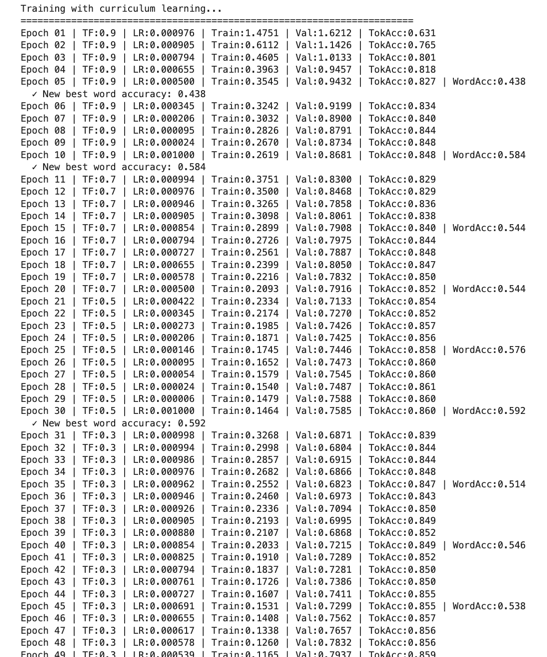

In [1]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Val Loss', marker='o', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('loss_curves.png', dpi=100)
plt.show()

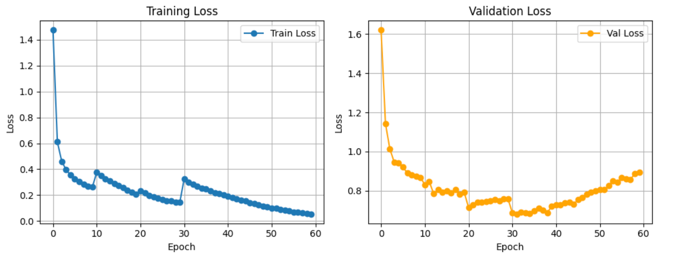

In [ ]:
def beam_search(model, src, vocab, beam_width=5, max_len=30):
    """Beam search decoding."""
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        src_tensor = torch.tensor(vocab.encode(src)).unsqueeze(0).to(device)
        src_len = torch.tensor([len(src)])

        _, (hidden, cell) = model.encoder(src_tensor, src_len)

        # Initialize beams: (score, sequence, hidden, cell)
        beams = [(0.0, [vocab.sos_idx], hidden, cell)]
        completed = []

        for _ in range(max_len):
            candidates = []

            for score, seq, h, c in beams:
                if seq[-1] == vocab.eos_idx:
                    completed.append((score, seq))
                    continue

                input_token = torch.tensor([[seq[-1]]]).to(device)
                output, new_h, new_c = model.decoder(input_token, h, c)
                log_probs = torch.log_softmax(output, dim=-1)

                topk_probs, topk_ids = log_probs.topk(beam_width)

                for prob, idx in zip(topk_probs[0], topk_ids[0]):
                    new_score = score + prob.item()
                    new_seq = seq + [idx.item()]
                    candidates.append((new_score, new_seq, new_h, new_c))

            if not candidates:
                break

            # Keep top beams
            candidates.sort(key=lambda x: x[0], reverse=True)
            beams = candidates[:beam_width]

            # Check if all beams completed
            if all(b[1][-1] == vocab.eos_idx for b in beams):
                completed.extend([(b[0], b[1]) for b in beams])
                break

        # Add remaining beams
        completed.extend([(b[0], b[1]) for b in beams])

        if not completed:
            return src  # Return original if nothing found

        # Return best result
        best = max(completed, key=lambda x: x[0] / len(x[1]))  # Length normalize
        return vocab.decode(best[1])


# Load best model
model.load_state_dict(torch.load('spellchecker_model.pt'))
model.eval()

# Test
print("\nTest Results:")
print("=" * 60)
test_cases = [
    # Intentional corruptions
    ('გამარჰობა', 'გამარჯობა'),      # h→j typo
    ('თბილსი', 'თბილისი'),           # missing ი
    ('პროგამა', 'პროგრამა'),         # missing რ
    ('საქართველო', 'საქართველო'),    # already correct
    ('კომპიუტრე', 'კომპიუტერი'),     # wrong ending
    ('ყველაზ', 'ყველაზე'),           # missing ე
    ('მადლობა', 'მადლობა'),          # already correct
    ('ქალაქი', 'ქალაქი'),            # already correct
    ('სკოლა', 'სკოლა'),              # already correct
    ('უნივრესიტეტი', 'უნივერსიტეტი'), # wrong character

    # Transpositions
    ('თიბლისი', 'თბილისი'),          # swapped თი→ბ
    ('საქრათველო', 'საქართველო'),    # swapped რა→არ

    # Deletions
    ('პროგრმა', 'პროგრამა'),         # missing ა
    ('საქრთველო', 'საქართველო'),     # missing ა

    # Insertions
    ('გამაარჯობა', 'გამარჯობა'),     # extra ა
    ('თბილიისი', 'თბილისი'),         # extra ი

    # Multiple errors
    ('პროგამ', 'პროგრამა'),          # missing რ and ა
    ('გმარჰობა', 'გამარჯობა'),       # missing ა, wrong ჰ

]

for inp, expected in test_cases:
    out_greedy = vocab.decode(model.decode_word(
        torch.tensor(vocab.encode(inp)).to(device), len(inp),
        vocab.sos_idx, vocab.eos_idx
    ))
    out_beam = beam_search(model, inp, vocab, beam_width=5)

    status_g = "✓" if out_greedy == expected else "✗"
    status_b = "✓" if out_beam == expected else "✗"
    print(f"{inp:20} | Greedy:{status_g} {out_greedy:20} | Beam:{status_b} {out_beam:20}")

In [ ]:
artifacts = {
    'vocab': vocab,
    'config': {
        'embed_dim': EMBED_DIM,
        'hidden_dim': HIDDEN_DIM,
        'dropout': DROPOUT,
    },
    'training_info': {
        'best_val_loss': best_val_loss,
        'best_word_acc': best_word_acc,
        'epochs_trained': len(train_losses),
    }
}

with open('spellchecker_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("Saved:")
print("  - spellchecker_model.pt")
print("  - spellchecker_artifacts.pkl")
print("  - training_curves.png")
print("  - georgian_words_cache.pkl")